> This is a self-correcting activity generated by [nbgrader](https://nbgrader.readthedocs.io). Fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Run subsequent cells to check your code.

---

# Generate handwritten digits with a GAN (PyTorch)

The goal here is to train a GAN to generate handwritten digits.

## Environment setup

In [1]:
import os
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import matplotlib
import matplotlib.pyplot as plt

Python version: 3.8.3


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'

In [13]:
import torch

print(f"PyTorch version: {torch.__version__}")
print("GPU found :)" if torch.cuda.is_available() else "No GPU :(")

import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.optim import Adam

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 1.5.1+cu101
GPU found :)


## Data loading

In [10]:
sample_dir = "samples"

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),  # only one channel
    ]
)

# MNIST dataset
mnist = torchvision.datasets.MNIST(
    root="./data/", train=True, transform=transform, download=True
)

### Question

Create batch data loader `data_loader` for training dataset.

In [18]:
batch_size = 100

data_loader = DataLoader(mnist, batch_size, shuffle=True)

## Model definition

### Question

Complete the following code to create a GAN:

- generator must be a dense network with two hidden layers using ReLU as activation functions;
- discriminator must be a dense network with two hidden layers using leaky ReLU as activation functions.

In [25]:
# Hyper-parameters
image_size = 784
hidden_size = 256
latent_size = 64

# Generator
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

# Device setting
G = G.to(device)
D = D.to(device)

## Loss, optimizer and utilities

### Question

Define optimizers `d_optimizer` and `g_optimizer`, both using Adam with  a learning rate of 0.0002.

In [26]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

d_optimizer = Adam(D.parameters(), lr=0.0002)
g_optimizer = Adam(G.parameters(), lr=0.0002)

In [27]:
def denorm(x):
    """Denormalize an image tensor"""
    out = (x + 1) / 2
    return out.clamp(0, 1)


def reset_grad():
    """Reset gradients for both optimizers"""
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

## Model training

### Question

Complete the following training loop to:

- compute fake images and output during discriminator training; 
- implement gradient descent.

In [29]:
num_epochs = 100 # Increase for a better output quality
step_count = len(data_loader)

# Start training
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since y == real_labels == 1
        real_outputs = D(images)
        d_loss_real = criterion(real_outputs, real_labels)
        real_score = real_outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since y == fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        
        fake_outputs = D(G(z))
        d_loss_fake = criterion(fake_outputs, fake_labels)
        fake_score = fake_outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i + 1) % 200 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}]"
                f", Step [{i + 1}/{step_count}]"
                f", d_loss: {d_loss.item():.4f}"
                f", g_loss: {g_loss.item():.4f}"
                f", D(x): {real_score.mean().item():.2f}"
                f", D(G(z)): {fake_score.mean().item():.2f}"
            )

    # Save real images
    if (epoch + 1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, "real_images.png"))

    # Save sampled images
    if (epoch + 1) % 10 == 0:
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        save_image(
            denorm(fake_images),
            os.path.join(sample_dir, f"fake_images-{epoch + 1}.png"),
        )

Epoch [1/100], Step [200/600], d_loss: 0.6007, g_loss: 3.6147, D(x): 0.86, D(G(z)): 0.20
Epoch [1/100], Step [400/600], d_loss: 0.5483, g_loss: 3.5827, D(x): 0.89, D(G(z)): 0.21
Epoch [1/100], Step [600/600], d_loss: 0.5227, g_loss: 3.6256, D(x): 0.81, D(G(z)): 0.13
Epoch [2/100], Step [200/600], d_loss: 0.4791, g_loss: 3.2489, D(x): 0.88, D(G(z)): 0.19
Epoch [2/100], Step [400/600], d_loss: 0.4201, g_loss: 3.4851, D(x): 0.92, D(G(z)): 0.18
Epoch [2/100], Step [600/600], d_loss: 0.4422, g_loss: 2.7473, D(x): 0.88, D(G(z)): 0.18
Epoch [3/100], Step [200/600], d_loss: 0.4388, g_loss: 3.0493, D(x): 0.86, D(G(z)): 0.14
Epoch [3/100], Step [400/600], d_loss: 0.6609, g_loss: 2.6586, D(x): 0.84, D(G(z)): 0.25
Epoch [3/100], Step [600/600], d_loss: 0.4162, g_loss: 3.1871, D(x): 0.86, D(G(z)): 0.14
Epoch [4/100], Step [200/600], d_loss: 0.2701, g_loss: 3.4772, D(x): 0.94, D(G(z)): 0.14
Epoch [4/100], Step [400/600], d_loss: 0.6854, g_loss: 2.7055, D(x): 0.72, D(G(z)): 0.09
Epoch [4/100], Step [

## Generate digits

In [23]:
def plot_image(image):
    # Convert PyTorch tensor to NumPy
    img_tensor = image.cpu().numpy() if torch.cuda.is_available() else image.numpy()
    plt.imshow(img_tensor.squeeze(), cmap="binary")
    plt.axis("off")

def show_images(images, n_images=batch_size):
    fig = plt.figure(figsize=(6, 10))
    for image_index in range(n_images):
        plt.subplot(13, 8, 1 + image_index)
        plot_image(images[image_index])

### Question

Use the trained generator to create fake images from Gaussian noise.

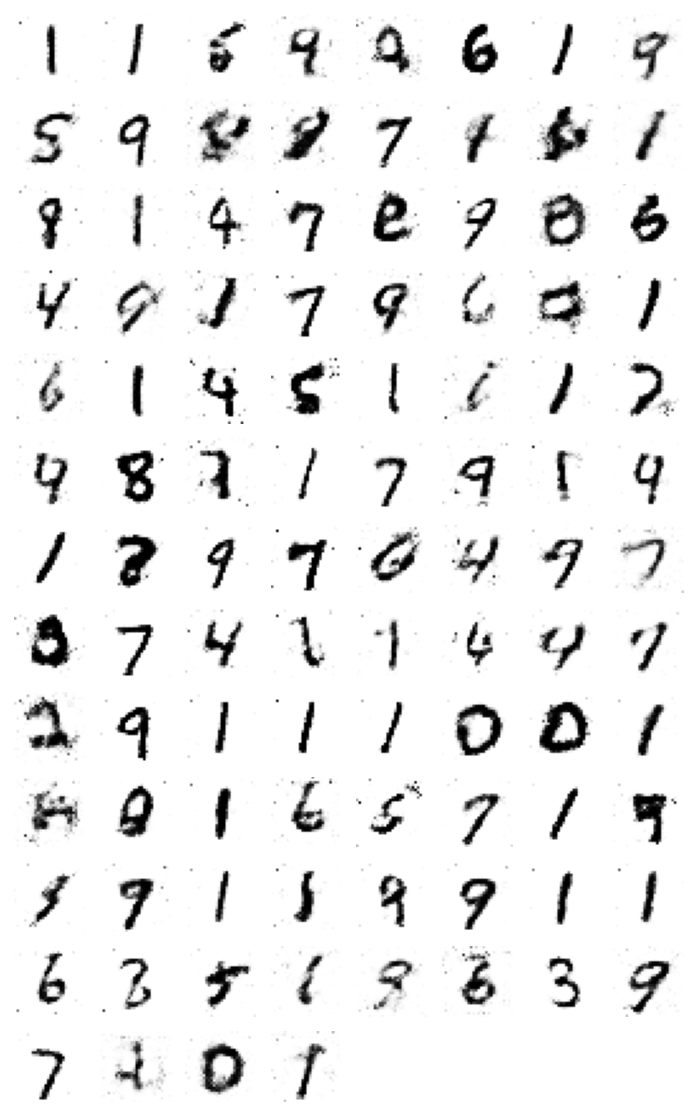

In [30]:
noise = torch.randn(batch_size, latent_size).to(device)
fake_images = G(noise)

with torch.no_grad():
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    show_images(fake_images)
